In [1]:
""" 
We will use subversion to get only 1 folder from our github repo, 
instead of cloning the entire repository using git.clone
(Done by replacing ".../tree/main/S8" with ".../trunk/S8")
"""
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 13 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [2]:
!svn update S8
!svn checkout https://github.com/AkhilP9182/EVA5---Extensive-Vision-AI/trunk/S8

Skipped 'S8'
svn: E155007: None of the targets are working copies
A    S8/README.md
A    S8/config.py
A    S8/images
A    S8/images/sf
A    S8/models
A    S8/models/README.md
A    S8/resnet.py
A    S8/resnet18_architecture.png
A    S8/train_test.py
A    S8/utilities.py
Checked out revision 134.


In [3]:
""" Our folder S7 (which contains all the required files) has been downloaded into the root folder"""
%ls

S8/  sample_data/


In [4]:
import os
folder_name = "S8/"
print("Python files in the folder {}".format(folder_name))
for root, dirs, files in os.walk(folder_name):
    for filename in files:
        if (".py" in filename and ".pyc" not in filename):
            print(filename)

Python files in the folder S8/
config.py
train_test.py
resnet.py
utilities.py


We can see that all the required files have been downloaded

### **Importing required packages**

In [5]:
# Importing the necessary packages
import sys
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Importing the custom classes and functions
import S8.config as config
import S8.utilities as util
from S8.resnet import ResNet18
from S8.train_test import train,test

### **Load Train/Test datasets (with the new mean and std deviation normalization)**

#### Calculate mean and std. deviation of combined (train+test) data

In [8]:
SEED = 1  # Set Randomization seed for Reproducible results
torch.manual_seed(SEED)                 

if config.USE_CUDA:
    torch.cuda.manual_seed(SEED)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = config.to_tensor)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = config.to_tensor)

mean_cifar10, std_cifar10 = util.get_mean_std_overall(trainset,testset)

mean_cifar10 = tuple(mean_cifar10.numpy())
std_cifar10 = tuple(std_cifar10.numpy())

print("\nChannelwise Mean of overall CIFAR 10 dataset:\t\t\t{}".format(mean_cifar10))         # mean_cifar10 = (0.49186122, 0.48266134, 0.44720834)
print("Channelwise Standrad Deviation of overall CIFAR 10 dataset:\t{}\n".format(std_cifar10)) # std_cifar10 = (0.24699295, 0.24340236, 0.26160896)

util.dataset_info(trainset,testset)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Channelwise Mean of overall CIFAR 10 dataset:			(0.49186122, 0.48266134, 0.44720834)
Channelwise Standrad Deviation of overall CIFAR 10 dataset:	(0.24699295, 0.24340236, 0.26160896)

Number of classes in CIFAR10   : 10
Number of images for training  : 50000
Number of images for validation: 10000


'Data loading done!'

#### Use loader function to make a loader iterator

In [9]:
# del trainset,testset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = config.train_transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = config.test_transform)
# The mean and std for CIFAR10 are already saved in config.py file, for the train and test loaders respectively

train_loader  = util.train_loader_cifar10(trainset, shuffle = True , num_workers = config.num_workers)
test_loader   = util.test_loader_cifar10(testset,   shuffle = False, num_workers = config.num_workers)
classes = config.CIFAR_classes
print(classes)
num_classes = len(classes)
print("\nNumber of classes = {}".format(num_classes))

Files already downloaded and verified
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of classes = 10


### **Plot some images from test set**

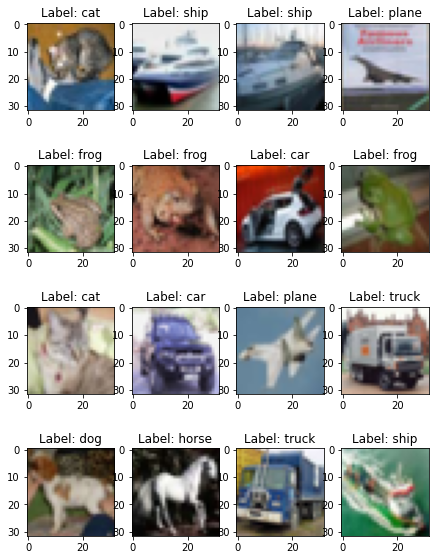

In [10]:
util.plot_images(test_loader, rows=4, cols=4, 
                 mean = mean_cifar10, std=std_cifar10, 
                 classes = list(config.CIFAR_classes))

## **Model Summary**

In [11]:
device = config.DEVICE                                # Selects whether to run the model on GPU or CPU
model = ResNet18().to(device)                         # Loads the model weights on the gpu or cpu
summary(model, input_size=config.input_size_CIFAR10)  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **Training and Testing the model**

In [12]:
epochs = config.EPOCHS             # No. of training epochs

train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

optimizer = optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = config.LR_STEP, gamma=config.LR_GAMMA)
# 

max_test_acc = 0
for epoch in range(0, epochs):
    train_loss,train_acc = train(model, config.DEVICE, train_loader, optimizer, epoch, L2_param = 0.005)
    test_loss,test_acc   = test(model, config.DEVICE, test_loader)
    if (test_acc > max_test_acc): # Save the best performing model
        model_path = 'S8/models/S8_best_resnet18_model.model'
        torch.save(model.state_dict(), model_path)
        max_test_acc = test_acc
        print("Model saved at epoch {}".format(epoch))
    scheduler.step()       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.002
Train Set: Mean loss: 1.0905, Train Accuracy: 30331/50000 (60.66%)
Test Set : Mean loss: 1.0770, Test Accuracy : 6130/10000 (61.30%)

Model saved at epoch 0



Epoch:1 Learning Rate:0.002
Train Set: Mean loss: 0.8133, Train Accuracy: 35603/50000 (71.21%)
Test Set : Mean loss: 0.8007, Test Accuracy : 7200/10000 (72.00%)

Model saved at epoch 1



Epoch:2 Learning Rate:0.002
Train Set: Mean loss: 0.7628, Train Accuracy: 36564/50000 (73.13%)
Test Set : Mean loss: 0.7629, Test Accuracy : 7375/10000 (73.75%)

Model saved at epoch 2



Epoch:3 Learning Rate:0.002
Train Set: Mean loss: 0.6444, Train Accuracy: 38477/50000 (76.95%)
Test Set : Mean loss: 0.6350, Test Accuracy : 7802/10000 (78.02%)

Model saved at epoch 3



Epoch:4 Learning Rate:0.0016
Train Set: Mean loss: 0.5045, Train Accuracy: 41155/50000 (82.31%)
Test Set : Mean loss: 0.5395, Test Accuracy : 8148/10000 (81.48%)

Model saved at epoch 4



Epoch:5 Learning Rate:0.0016
Train Set: Mean loss: 0.4462, Train Accuracy: 42381/50000 (84.76%)
Test Set : Mean loss: 0.5083, Test Accuracy : 8277/10000 (82.77%)

Model saved at epoch 5



Epoch:6 Learning Rate:0.0016
Train Set: Mean loss: 0.4248, Train Accuracy: 42623/50000 (85.25%)
Test Set : Mean loss: 0.4722, Test Accuracy : 8366/10000 (83.66%)

Model saved at epoch 6



Epoch:7 Learning Rate:0.0016
Train Set: Mean loss: 0.4180, Train Accuracy: 42798/50000 (85.60%)
Test Set : Mean loss: 0.4709, Test Accuracy : 8341/10000 (83.41%)




Epoch:8 Learning Rate:0.00128
Train Set: Mean loss: 0.3644, Train Accuracy: 43756/50000 (87.51%)
Test Set : Mean loss: 0.4426, Test Accuracy : 8457/10000 (84.57%)

Model saved at epoch 8



Epoch:9 Learning Rate:0.00128
Train Set: Mean loss: 0.3361, Train Accuracy: 44279/50000 (88.56%)
Test Set : Mean loss: 0.4169, Test Accuracy : 8626/10000 (86.26%)

Model saved at epoch 9



Epoch:10 Learning Rate:0.00128
Train Set: Mean loss: 0.3279, Train Accuracy: 44247/50000 (88.49%)
Test Set : Mean loss: 0.4079, Test Accuracy : 8578/10000 (85.78%)




Epoch:11 Learning Rate:0.00128
Train Set: Mean loss: 0.3498, Train Accuracy: 43803/50000 (87.61%)
Test Set : Mean loss: 0.4473, Test Accuracy : 8445/10000 (84.45%)




Epoch:12 Learning Rate:0.0010240000000000002
Train Set: Mean loss: 0.2482, Train Accuracy: 45784/50000 (91.57%)
Test Set : Mean loss: 0.3403, Test Accuracy : 8846/10000 (88.46%)

Model saved at epoch 12



Epoch:13 Learning Rate:0.0010240000000000002
Train Set: Mean loss: 0.2806, Train Accuracy: 45185/50000 (90.37%)
Test Set : Mean loss: 0.3874, Test Accuracy : 8701/10000 (87.01%)




Epoch:14 Learning Rate:0.0010240000000000002
Train Set: Mean loss: 0.2303, Train Accuracy: 46086/50000 (92.17%)
Test Set : Mean loss: 0.3491, Test Accuracy : 8824/10000 (88.24%)




Epoch:15 Learning Rate:0.0010240000000000002
Train Set: Mean loss: 0.2467, Train Accuracy: 45767/50000 (91.53%)
Test Set : Mean loss: 0.3681, Test Accuracy : 8725/10000 (87.25%)




Epoch:16 Learning Rate:0.0008192000000000002
Train Set: Mean loss: 0.2164, Train Accuracy: 46319/50000 (92.64%)
Test Set : Mean loss: 0.3378, Test Accuracy : 8891/10000 (88.91%)

Model saved at epoch 16



Epoch:17 Learning Rate:0.0008192000000000002
Train Set: Mean loss: 0.1819, Train Accuracy: 46987/50000 (93.97%)
Test Set : Mean loss: 0.3075, Test Accuracy : 9000/10000 (90.00%)

Model saved at epoch 17



Epoch:18 Learning Rate:0.0008192000000000002
Train Set: Mean loss: 0.2007, Train Accuracy: 46621/50000 (93.24%)
Test Set : Mean loss: 0.3300, Test Accuracy : 8903/10000 (89.03%)




Epoch:19 Learning Rate:0.0008192000000000002
Train Set: Mean loss: 0.1724, Train Accuracy: 47142/50000 (94.28%)
Test Set : Mean loss: 0.3080, Test Accuracy : 8965/10000 (89.65%)




Epoch:20 Learning Rate:0.0006553600000000002
Train Set: Mean loss: 0.1593, Train Accuracy: 47368/50000 (94.74%)
Test Set : Mean loss: 0.3034, Test Accuracy : 8987/10000 (89.87%)




Epoch:21 Learning Rate:0.0006553600000000002
Train Set: Mean loss: 0.1282, Train Accuracy: 47973/50000 (95.95%)
Test Set : Mean loss: 0.2827, Test Accuracy : 9061/10000 (90.61%)

Model saved at epoch 21



Epoch:22 Learning Rate:0.0006553600000000002
Train Set: Mean loss: 0.1454, Train Accuracy: 47633/50000 (95.27%)
Test Set : Mean loss: 0.3007, Test Accuracy : 8994/10000 (89.94%)




Epoch:23 Learning Rate:0.0006553600000000002
Train Set: Mean loss: 0.1389, Train Accuracy: 47754/50000 (95.51%)
Test Set : Mean loss: 0.2947, Test Accuracy : 9023/10000 (90.23%)




Epoch:24 Learning Rate:0.0005242880000000002
Train Set: Mean loss: 0.1124, Train Accuracy: 48227/50000 (96.45%)
Test Set : Mean loss: 0.2830, Test Accuracy : 9058/10000 (90.58%)




Epoch:25 Learning Rate:0.0005242880000000002
Train Set: Mean loss: 0.1045, Train Accuracy: 48421/50000 (96.84%)
Test Set : Mean loss: 0.2846, Test Accuracy : 9075/10000 (90.75%)

Model saved at epoch 25



Epoch:26 Learning Rate:0.0005242880000000002
Train Set: Mean loss: 0.0939, Train Accuracy: 48633/50000 (97.27%)
Test Set : Mean loss: 0.2700, Test Accuracy : 9095/10000 (90.95%)

Model saved at epoch 26



Epoch:27 Learning Rate:0.0005242880000000002
Train Set: Mean loss: 0.1094, Train Accuracy: 48309/50000 (96.62%)
Test Set : Mean loss: 0.2935, Test Accuracy : 9030/10000 (90.30%)




Epoch:28 Learning Rate:0.00041943040000000023
Train Set: Mean loss: 0.0829, Train Accuracy: 48771/50000 (97.54%)
Test Set : Mean loss: 0.2774, Test Accuracy : 9107/10000 (91.07%)

Model saved at epoch 28



Epoch:29 Learning Rate:0.00041943040000000023
Train Set: Mean loss: 0.0646, Train Accuracy: 49187/50000 (98.37%)
Test Set : Mean loss: 0.2607, Test Accuracy : 9157/10000 (91.57%)

Model saved at epoch 29


## Loss and Accuracy Plots

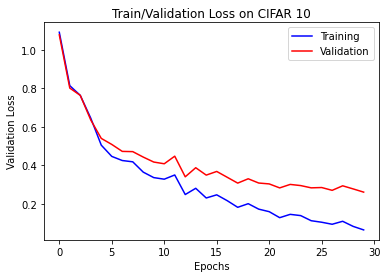

In [13]:
util.plot_loss(train_loss_vals,test_loss_vals,epochs)

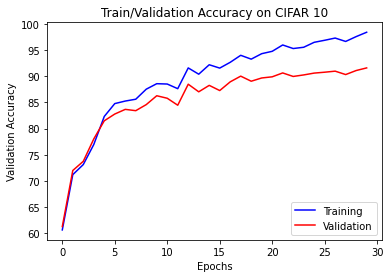

In [14]:
util.plot_acc(train_acc_vals,test_acc_vals,epochs)

## **Plot Correctly Classified Images and their predictions**

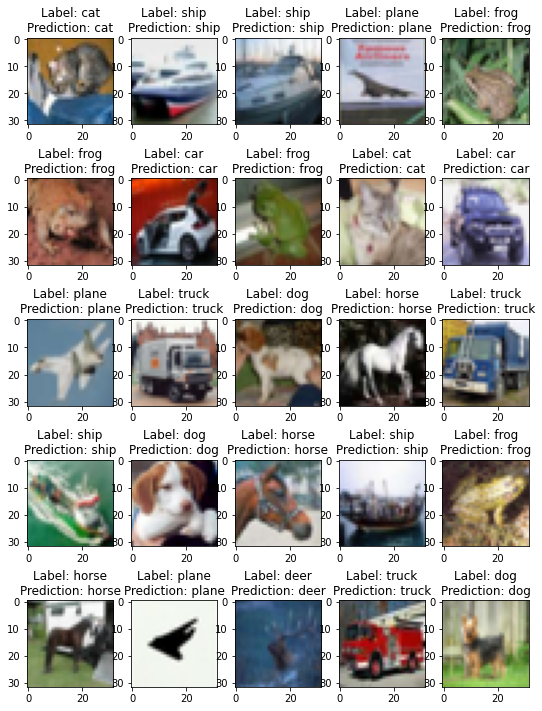

In [15]:
util.plot_correct_classified(ResNet18,"S8/models/S8_best_resnet18_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)

## **Plot Misclassified Images and their predictions**

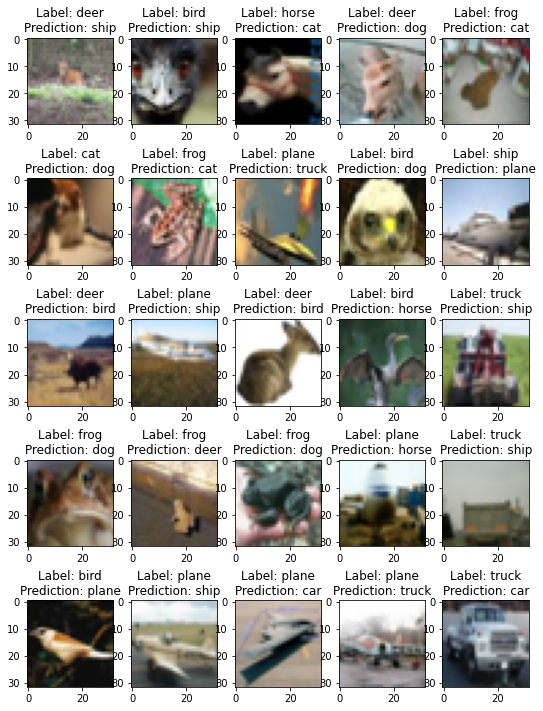

In [16]:
util.plot_misclassified(ResNet18,"S8/models/S8_best_resnet18_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)